# EfficientNetV2B0

O EfficientNetV2B0 é parte da família de CNNs [EfficientNet](https://keras.io/api/applications/efficientnet_v2/), desenvolvida pela Google. O modelo é conhecido por ser a menor versão e mais leve da série B0, voltada para dispositivos com recursos limitados (como embarcados), mas sem perder tanto a níveis de desempenho.

Para este estudo, será testado o desempenho do modelo para a classificação multi-classe de imagens dermoscópicas (tiradas via dermastocópio, instrumento médico próprio para examinar lesões de pele com detalhees invisíveis a olho nu) de doenças dermatológicas. As imagens foram retiradas do [PUMCH-ISD](https://www.kaggle.com/datasets/jcwang10000/pumch-isd/data), um dataset com mais de 7000 imagens dermoscópicas de diferentes pacientes.

## Importando bibliotecas

Espaço para importações. Serão utilizadas: 
* **cv2** para a manipulação das imagens,
* **matplotlib** e **seaborn** para a visualização gráfica,
* **numpy** para operações matemáticas,
* **sklearn** para a divisão do dataset e cálculo de métricas,
* **keras** para importação, ajuste e treino do EfficientNetV2B0 e
* **os** para a manipulação de arquivos.

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array

# WARNINGS
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["XLA_FLAGS"] = "--xla_gpu_disabled=true"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

### Definindo constantes

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 200
PATH = "/kaggle/input/pumch-isd/PUMCH-ISD"

### Conhecendo o conjunto de dados

Ainda que o dataset original possua tanto imagens clínicas quanto dermoscópicas, foi-se escolhido treinar para com o segundo grupo de imagens, isto porque a inconstância das imagens clínicas (como a presença de faixas pretas) poderia enviesar os resultados de alguma forma. 

In [3]:
image_paths = []
labels = []

class_names = sorted(os.listdir(PATH)) 
class_index = {name: idx for idx, name in enumerate(class_names)}

for disease_name in class_names:
    disease_path = os.path.join(PATH, disease_name)
    
    if os.path.isdir(disease_path):
        dermoscopy_path = os.path.join(disease_path, "dermoscopy")

        if os.path.exists(dermoscopy_path):
            for img_file in os.listdir(dermoscopy_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(dermoscopy_path, img_file)
                    image_paths.append(img_path)

                    labels.append(class_index[disease_name])

In [4]:
print(f"Doenças: {class_names}")
print(f"Qtde de imagens: {len(image_paths)}")

Doenças: ['Acne vulgaris', 'Dermatitis_subset1', 'Dermatitis_subset2', 'Lichen planus', 'Morphea', 'Pityriasis rosea', 'Psoriasis', 'Rosacea', 'Vitiligo']
Qtde de imagens: 7798


Assim, o modelo será treinado para classificar 9 diferentes tipos de doenças dermatológicas. A seguir, as imagens passam por um processo de pre-processamento em que são redimensionadas para o tamanho 224x224 (as originais eram muito grandes, o que dificultaria o treinamento da rede) e convertidas para um array numpy de três dimensões (Height, Weight, Chanels).

In [5]:
images = []
processed_labels = []

for img_path, label in zip(image_paths, labels):
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img)
    img = preprocess_input(img) 
        
    images.append(img)
    processed_labels.append(label)

images = np.array(images)
processed_labels = np.array(processed_labels)

Depois, as imagens são divididas em partições de treino, validação e teste, com seed padrão em 42 e uma partição 70/30.

In [6]:
X = np.array(images)
y = np.array(processed_labels)

X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

Tendo em vista o desbalanceamento de algumas classes, é preferível treinar a rede considerando os pesos proporcionais a cada categoria de imagem. As classes de maiores pesos, que também são aquelas que possuem menos amostras, serão preferíveis no momento da classificação.

In [18]:
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)

class_weight = dict(zip(classes, weights))
print(class_weight)

{0: 0.7350841750841751, 1: 0.6907112123513035, 2: 1.447361442588173, 3: 1.0492118415993847, 4: 1.0510302330059695, 5: 3.1421991940126657, 6: 0.622632899840292, 7: 0.8789049919484702, 8: 1.8717421124828533}


### Definindo o modelo

In [19]:
model = EfficientNetV2B0(
    include_top = True, 
    weights = "imagenet",
    input_tensor = None,
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    pooling = None,
    classes = 1000,
    classifier_activation = "softmax",
    include_preprocessing = True,
    name = "efficientnetv2-b0",
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 7,200,312 (27.47 MB)

 Trainable params: 7,139,704 (27.24 MB)

 Non-trainable params: 60,608 (236.75 KB)

Após a definição do modelo, é iniciado o treinamento. É setado um callback de parada com base nos valores de validação a fim de otimizar o tempo e o desempenho do treino da rede.

In [21]:
callback = EarlyStopping(
    monitor='val_loss',   
    patience=10,          
    restore_best_weights=True 
)

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[callback],
    class_weight=class_weight
)

Epoch 1/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 144s 385ms/step - accuracy: 0.4044 - loss: 2.3524 - val_accuracy: 0.6274 - val_loss: 1.0854
Epoch 2/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.6519 - loss: 0.8893 - val_accuracy: 0.6385 - val_loss: 0.9980
Epoch 3/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.7552 - loss: 0.6372 - val_accuracy: 0.6940 - val_loss: 0.9062
Epoch 4/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8043 - loss: 0.4914 - val_accuracy: 0.7504 - val_loss: 0.7286
Epoch 5/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.8415 - loss: 0.3849 - val_accuracy: 0.7214 - val_loss: 0.8700
Epoch 6/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8545 - loss: 0.3582 - val_accuracy: 0.6855 - val_loss: 1.0317
Epoch 7/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.8922 - loss: 0.2538 - val_accuracy: 0.7256 - val_loss: 0.9912
Epoch 8/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.9162 

### Conferindo o desempenho do modelo

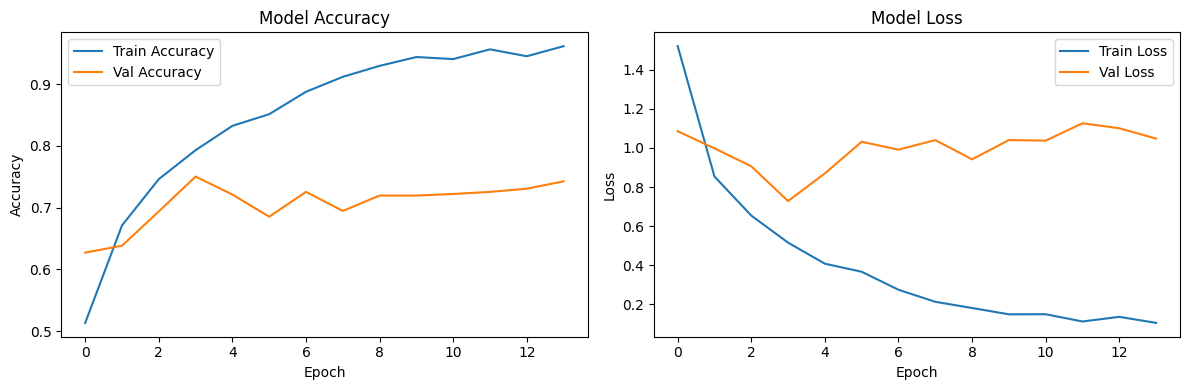

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
    
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
    
plt.tight_layout()
plt.show()

As métricas de avaliação utilizadas serão precisão, recall, f1-score e acurácia para cada uma das classes preditas. 

                    precision    recall  f1-score   support

     Acne vulgaris       0.91      0.88      0.89       177
Dermatitis_subset1       0.63      0.62      0.62       189
Dermatitis_subset2       0.45      0.66      0.53        90
     Lichen planus       0.88      0.81      0.84       124
           Morphea       0.81      0.77      0.79       123
  Pityriasis rosea       0.81      0.71      0.75        41
         Psoriasis       0.69      0.81      0.74       209
           Rosacea       0.81      0.65      0.72       148
          Vitiligo       0.88      0.65      0.75        69

          accuracy                           0.74      1170
         macro avg       0.76      0.73      0.74      1170
      weighted avg       0.76      0.74      0.74      1170



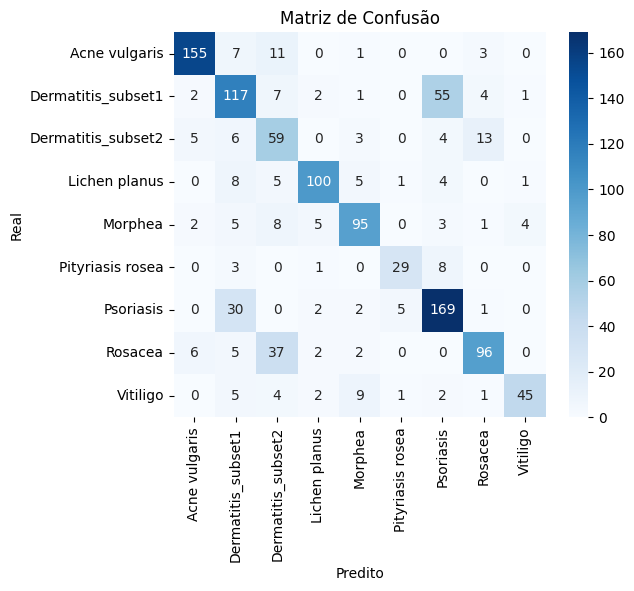

In [23]:
y_pred = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)  

cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, 
                            target_names=class_names, 
                            zero_division=0))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

Como a acurácia não é uma métrica padrão imprimida no classification report para casos multiclasse, ela deve ser calculada separadamente pela fórmula: 
$$
\text{Acurácia} = \frac{\text{Número de predições corretas}}{\text{Número total de amostras}}
$$

In [24]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

for cls, acc in zip(class_names, class_accuracy):
    print(f"{cls}: {acc:.4f}")

Acne vulgaris: 0.8757
Dermatitis_subset1: 0.6190
Dermatitis_subset2: 0.6556
Lichen planus: 0.8065
Morphea: 0.7724
Pityriasis rosea: 0.7073
Psoriasis: 0.8086
Rosacea: 0.6486
Vitiligo: 0.6522
